## Flower (Video)

### created by Yuying Liu, 06/09/2020

This script is used to do sequence generation on the blooming flower video frame, which can be used to reproduce a row in Figure 7.

In [2]:
# imports
import os
import sys
import cv2
import torch
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
from matplotlib import animation
from IPython.display import Video
from IPython.display import HTML
from scipy.linalg import svd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# # # # # # # # # # # # # # # # # #
#  global constants, paths, etc.  #
# # # # # # # # # # # # # # # # # #
data_dir = '../../data/Flower/'
result_dir = '../../results/Flower/'

## Part I

### process data

In [4]:
# retrieve data
# cap = cv2.VideoCapture(os.path.join(data_dir, 'flower.mp4'))
cap = cv2.VideoCapture('flower.mp4')

frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
data = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
print(data.shape)

ret = True
for i in tqdm(range(frameCount)):
    if not ret:
        break
    else:
        ret, data[i] = cap.read()
cap.release()

(175, 540, 960, 3)


  0%|          | 0/175 [00:00<?, ?it/s]

In [5]:
# animation of original video
def plot_images(img_list):
    def init():
        print(img_list[0].shape)
        img.set_data(cv2.cvtColor(img_list[0], cv2.COLOR_BGR2RGB))
        return (img,)
    def animate(i):
        img.set_data(cv2.cvtColor(img_list[i], cv2.COLOR_BGR2RGB))
        return (img,)

    fig = plt.figure(figsize=(12, 8))
    plt.axis('off')
    ax = fig.gca()
    img = ax.imshow(cv2.cvtColor(img_list[0], cv2.COLOR_BGR2RGB))
    plt.close();
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(img_list), interval=20, blit=True)
    return anim

imgs = [data[i, :, :, :] for i in range(frameCount)]
HTML(plot_images(imgs).to_html5_video())

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


In [6]:
data.shape

(175, 540, 960, 3)

In [7]:
data.shape

(175, 540, 960, 3)

In [ ]:
# dimensionality reduction
raw_data = data.reshape(frameCount, -1).T
U, s, VT = svd(raw_data, full_matrices=False)
reduced_data = U[:, :64].dot(np.diag(s[:64]).dot(VT[:64, :])).T.reshape(frameCount, frameHeight, frameWidth, 3)
reduced_data[reduced_data < 0] = 0
reduced_data[reduced_data > 255] = 255
coord_dynamics = VT[:64, :]
# np.save(os.path.join(data_dir, 'data.npy'), coord_dynamics)   # <-- this is the data set for training NNs

np.save(os.path.join(data_dir, 'U.npy'), U) 
np.save(os.path.join(data_dir, 's.npy'), s) 

In [9]:
print(U)

[[ 2.4985638e-08  9.0779395e-08  1.8156607e-07 ... -1.3359428e-05
   5.2543110e-05 -4.6314599e-06]
 [-6.6148687e-10 -3.7710777e-09 -2.6012685e-09 ... -6.9688934e-07
  -8.5208814e-07 -1.9139522e-06]
 [ 2.9215244e-09  1.8147830e-09  8.0487608e-09 ...  4.6773757e-06
  -2.0014672e-06  3.1486047e-07]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]


In [8]:
data = coord_dynamics.T
n_steps = 175
step_size = 16
n_forward = 3
m = int(np.ceil(n_steps/(49)*3))
pdata = np.zeros((m, step_size*n_forward+1, data.shape[1]))
for i in range(m):
    start_idx = i*int(step_size*n_forward/3)
    end_idx = start_idx + step_size*n_forward + 1
    tmp = data[start_idx:end_idx, :]
    pdata[i, :tmp.shape[0], :] = tmp
    
print(pdata.shape)

(11, 49, 64)


In [31]:
49/16

3.0625

In [34]:
pdata.shape

(11, 49, 64)

In [35]:
np.save(os.path.join(data_dir, 'train_noise0.0.npy'), pdata) 
np.save(os.path.join(data_dir, 'test_noise0.0.npy'), data.reshape(1, 175, 64)) 

In [15]:
# animation of low-dim reconstructed data
imgs = [reduced_data[i, :, :, :].astype('uint8') for i in range(frameCount)]
reduced_anim = plot_images(imgs)
reduced_anim.save(os.path.join(result_dir, 'flower_truth.mp4'))
HTML(reduced_anim.to_html5_video())

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/16kat/OneDrive - acornonsite.com/multiscale_Time_depends/results/Flower'

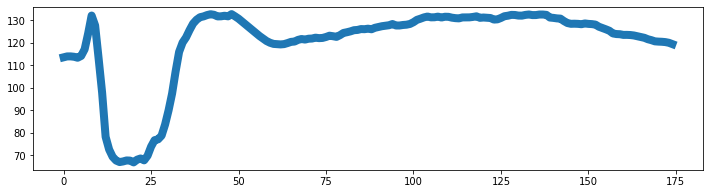

In [25]:
fig = plt.figure(figsize=(12, 3))
plt.plot(reduced_data[:, 320:360, 340:380, 0].mean(-1).mean(-1), linewidth=8.0)
# plt.xticks([], [])
# plt.yticks([], [])

In [ ]:
# fig = plt.figure(figsize=(12, 8))
# plt.axis('off')
# ax = fig.gca()
# img = ax.imshow(cv2.cvtColor(imgs[170], cv2.COLOR_BGR2RGB))

## Part II

<font color='red'>Attention: use seq_generations.ipynb to train differen architectures and generate target sequences before running part II. The code below requires numpy files Flower_{model}_pred.npy. </font>

### coupled NNs

In [ ]:
# coupled NN reconstruction
coupled_nn_V = np.load(os.path.join(result_dir, 'flower_couple_pred.npy'))
coupled_nn_data = U[:, :64].dot(np.diag(s[:64]).dot(coupled_nn_V.T)).T.reshape(frameCount, frameHeight, frameWidth, 3)
coupled_nn_data[coupled_nn_data < 0] = 0
coupled_nn_data[coupled_nn_data > 255] = 255

print(((coupled_nn_V - VT[:64, :].T)**2).mean())
plt.figure(figsize = (16, 1))
plt.plot(((coupled_nn_V - VT[:64, :].T)**2).mean(0))

In [ ]:
# animation of reconstruction via coupled NNs
imgs = [coupled_nn_data[i, :, :, :].astype('uint8') for i in range(frameCount)]
coupled_anim = plot_images(imgs)
coupled_anim.save(os.path.join(result_dir, 'flower_couple_pred.mp4'))
HTML(coupled_anim.to_html5_video())

In [ ]:
fig = plt.figure(figsize=(12, 3))
plt.plot(coupled_nn_data[:, 150:180, 250:280, 0].mean(-1).mean(-1), linewidth=8.0)
plt.xticks([], [])
plt.yticks([], [])

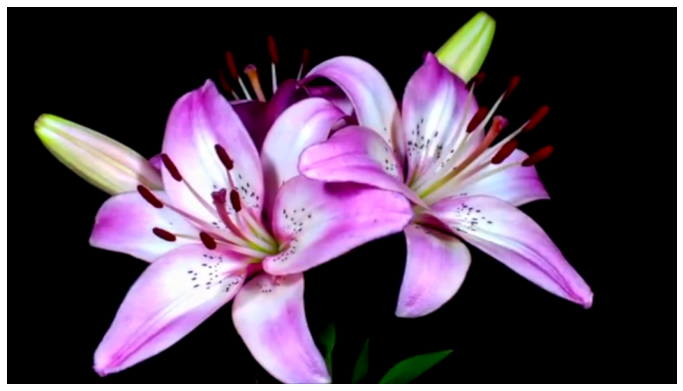

In [8]:
fig = plt.figure(figsize=(12, 8))
plt.axis('off')
ax = fig.gca()
img = ax.imshow(cv2.cvtColor(imgs[170], cv2.COLOR_BGR2RGB))

### lstm

In [ ]:
# lstm reconstruction
lstm_V = np.load(os.path.join(result_dir, 'flower_lstm_pred.npy'))
lstm_data = U[:, :64].dot(np.diag(s[:64]).dot(lstm_V.T)).T.reshape(frameCount, frameHeight, frameWidth, 3)
lstm_data[lstm_data < 0] = 0
lstm_data[lstm_data > 255] = 255

print(((lstm_V - VT[:64, :].T)**2).mean())
plt.figure(figsize = (16, 1))
plt.plot(((lstm_V - VT[:64, :].T)**2).mean(0))

In [ ]:
# animation of reconstruction via lstm
imgs = [lstm_data[i, :, :, :].astype('uint8') for i in range(frameCount)]
lstm_anim = plot_images(imgs)
lstm_anim.save(os.path.join(result_dir, 'flower_LSTM_pred.mp4'))
HTML(lstm_anim.to_html5_video())

In [ ]:
fig = plt.figure(figsize=(12, 3))
plt.plot(lstm_data[:, 150:180, 250:280, 0].mean(-1).mean(-1), linewidth=8.0)
plt.xticks([], [])
plt.yticks([], [])

In [ ]:
# fig = plt.figure(figsize=(12, 8))
# plt.axis('off')
# ax = fig.gca()
# img = ax.imshow(cv2.cvtColor(imgs[170], cv2.COLOR_BGR2RGB))

### reservoir

In [ ]:
# reservoir reconstruction
reservoir_V = np.load(os.path.join(result_dir, 'flower_reservoir_pred.npy'))
reservoir_data = U[:, :64].dot(np.diag(s[:64]).dot(reservoir_V.T)).T.reshape(frameCount, frameHeight, frameWidth, 3)
reservoir_data[reservoir_data < 0] = 0
reservoir_data[reservoir_data > 255] = 255

print(((reservoir_V - VT[:64, :].T)**2).mean())
plt.figure(figsize = (16, 1))
plt.plot(((reservoir_V - VT[:64, :].T)**2).mean(0))

In [ ]:
# animation of reconstruction via reservoir
imgs = [reservoir_data[i, :, :, :].astype('uint8') for i in range(frameCount)]
reservoir_anim = plot_images(imgs)
reservoir_anim.save(os.path.join(result_dir, 'flower_Reservoir_pred.mp4'))
HTML(reservoir_anim.to_html5_video())

In [ ]:
fig = plt.figure(figsize=(12, 3))
plt.plot(reservoir_data[:, 150:180, 250:280, 0].mean(-1).mean(-1), linewidth=8.0)
plt.xticks([], [])
plt.yticks([], [])

In [ ]:
# fig = plt.figure(figsize=(12, 8))
# plt.axis('off')
# ax = fig.gca()
# img = ax.imshow(cv2.cvtColor(imgs[170], cv2.COLOR_BGR2RGB))

### cwrnn

In [ ]:
# cwrnn reconstruction
cwrnn_V = np.load(os.path.join(result_dir, 'flower_cwrnn_pred.npy'))
cwrnn_data = U[:, :64].dot(np.diag(s[:64]).dot(cwrnn_V.T)).T.reshape(frameCount, frameHeight, frameWidth, 3)
cwrnn_data[cwrnn_data < 0] = 0
cwrnn_data[cwrnn_data > 255] = 255

print(((cwrnn_V - VT[:64, :].T)**2).mean())
plt.figure(figsize = (16, 1))
plt.plot(((cwrnn_V - VT[:64, :].T)**2).mean(0))

In [ ]:
# animation of reconstruction via cwrnn
imgs = [cwrnn_data[i, :, :, :].astype('uint8') for i in range(frameCount)]
cwrnn_anim = plot_images(imgs)
cwrnn_anim.save(os.path.join(result_dir, 'flower_CWRNN_pred.mp4'))
HTML(cwrnn_anim.to_html5_video())

In [ ]:
fig = plt.figure(figsize=(12, 3))
plt.plot(cwrnn_data[:, 150:180, 250:280, 0].mean(-1).mean(-1), linewidth=8.0)
plt.xticks([], [])
plt.yticks([], [])

In [ ]:
# fig = plt.figure(figsize=(12, 8))
# plt.axis('off')
# ax = fig.gca()
# img = ax.imshow(cv2.cvtColor(imgs[170], cv2.COLOR_BGR2RGB))